In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle("../data/dair-ai-emotions/merged_training.pkl")
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [3]:
surprise_count = len(df.loc[df['emotions'] == 'surprise'])

joy = df.loc[df['emotions'] == 'joy'].iloc[:surprise_count]
sadness = df.loc[df['emotions'] == 'sadness'].iloc[:surprise_count]
anger = df.loc[df['emotions'] == 'anger'].iloc[:surprise_count]
fear = df.loc[df['emotions'] == 'fear'].iloc[:surprise_count]
love = df.loc[df['emotions'] == 'love'].iloc[:surprise_count]
surprise = df.loc[df['emotions'] == 'surprise']

In [4]:
frames = [joy, sadness, anger, fear, love, surprise]
equal_dataset = pd.concat(frames)

np.random.shuffle(equal_dataset.values)
equal_dataset

,text,emotions
140764,i had this feeling of disappointment disappoin...,love
10714,i remember in particular one new years day in ...,sadness
35177,im feeling so cold inside,anger
122177,i learned that my girlfriend had been unjustly...,anger
98659,i am able to feel calm even others are not,joy
...,...,...
10560,i never felt that way about daughter if anythi...,love
5282,i have no issue of forgiving because i never f...,anger
6187,i feel more affectionate and thoughtful,love
6813,i feel about you im just curious,surprise


In [5]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = equal_dataset.iloc[:40000]

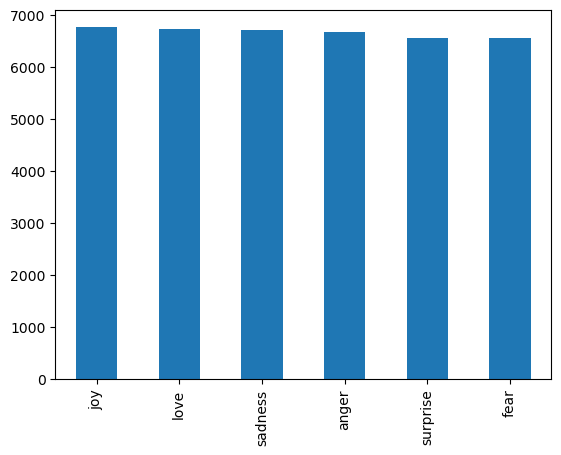

In [6]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [7]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [8]:
df = df.replace({"emotions": ordered_class_labels})

In [9]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['text', 'emotions'],
    num_rows: 40000
})

In [10]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [12]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [13]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=True):
    return hf_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["emotions"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
import Constants

# Callbacks
training_number = 4
model_name = "emotions_eng_bert"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [15]:
checkpoint_path

'../training_checkpoints\\emotions_eng_bert\\training_4\\cp-{epoch:04d}.ckpt'

In [16]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [17]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
2000/2000 [==============================] - 193s 90ms/step - loss: 0.3131 - accuracy: 0.8896 - val_loss: 0.1771 - val_accuracy: 0.9425

Epoch 00001: saving model to ../training_checkpoints\emotions_eng_bert\training_4\cp-0001.ckpt
Epoch 2/10
2000/2000 [==============================] - 179s 89ms/step - loss: 0.1370 - accuracy: 0.9473 - val_loss: 0.1301 - val_accuracy: 0.9495

Epoch 00002: saving model to ../training_checkpoints\emotions_eng_bert\training_4\cp-0002.ckpt
Epoch 3/10
2000/2000 [==============================] - 178s 89ms/step - loss: 0.1187 - accuracy: 0.9522 - val_loss: 0.1318 - val_accuracy: 0.9515

Epoch 00003: saving model to ../training_checkpoints\emotions_eng_bert\training_4\cp-0003.ckpt
Epoch 4/10
2000/2000 [==============================] - 185s 93ms/step - loss: 0.1095 - accuracy: 0.9555 - val_loss: 0.1347 - val_accuracy: 0.9498

Epoch 00004: saving model to ../training_checkpoints\emotions_eng_bert\training_4\cp-0004.ckpt
Epoch 5/10
2000/2000 [======

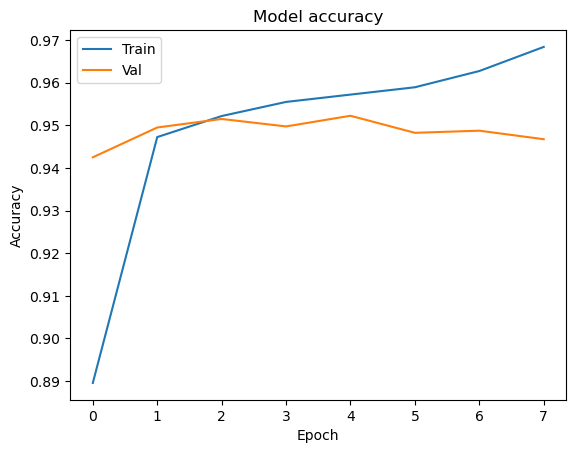

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

In [22]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [23]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_bert_4\1\assets


INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_bert_4\1\assets


In [24]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

250/250 [==============================] - 9s 34ms/step - loss: 0.1777 - accuracy: 0.9383


[0.17774651944637299, 0.9382500052452087]

In [ ]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)